# Logistic Regression with a Neural Network mindset

In this assignment we will build a **logistic regression classifier** to recognize cats. This assignment will step you through how to do this with a neural network mindset, and so will also hone your intuitions about deep learning.

### 0 - packages

Import all the packages that you will need during this assignment. [numpy](www.numpy.org) and [h5py](http://www.h5py.org).

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

### 1 - Overview of the problem set

In [2]:
train_dataset = h5py.File(r'datasets/train_catvnoncat.h5', 'r')
for key in train_dataset.keys():
    print(key)
    print(train_dataset[key].name)

list_classes
/list_classes
train_set_x
/train_set_x
train_set_y
/train_set_y


training_set_x shape:  (209, 64, 64, 3)
training_set_y shape:  (209,)


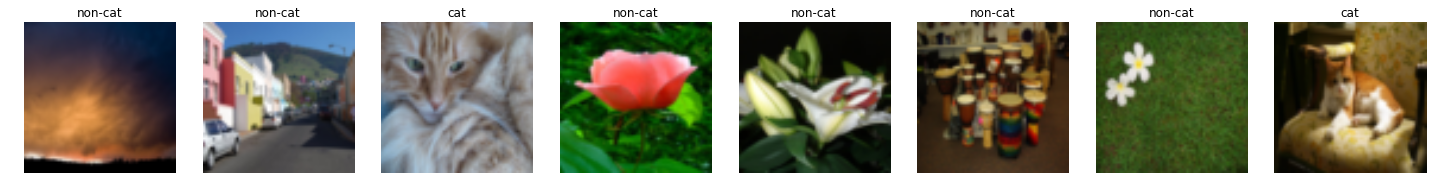

In [3]:
train_set_x_orig = np.array(train_dataset['train_set_x'])
print('training_set_x shape: ', train_set_x_orig.shape)
train_set_y_orig = np.array(train_dataset['train_set_y'])
print('training_set_y shape: ', train_set_y_orig.shape)
classes = np.array(train_dataset['list_classes'])
plt.rcParams['figure.figsize'] = (20, 20)
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(train_set_x_orig[i])
    plt.axis('off')
    plt.title(str(classes[train_set_y_orig[i]].decode('utf-8')))
plt.tight_layout()
plt.show()

In [4]:
def load_dataset():
    train_dataset = h5py.File(r'datasets/train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    
    test_dataset = h5py.File(r'datasets/test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    classes = np.array(test_dataset['list_classes'][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [6]:
print('number of training examples', train_set_x_orig.shape[0])
print('number of testing examples', test_set_x_orig.shape[0])
print('height/width of each image', train_set_x_orig.shape[1], train_set_x_orig.shape[2])
print('shape of train_x set', train_set_x_orig.shape)
print('shape of train_y set', train_set_y.shape)
print('shape of test_y set', test_set_x_orig.shape)
print('shape of test_y set', test_set_y.shape)
print('classes list:', classes)

number of training examples 209
number of testing examples 50
height/width of each image 64 64
shape of train_x set (209, 64, 64, 3)
shape of train_y set (1, 209)
shape of test_y set (50, 64, 64, 3)
shape of test_y set (1, 50)
classes list: [b'non-cat' b'cat']


it's a cat picture


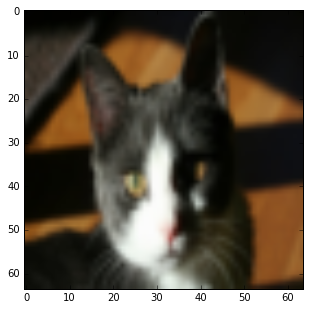

In [7]:
index = 19
plt.rcParams['figure.figsize'] = (5, 5)
print("it's a " + str(classes[np.squeeze(train_set_y[:, index])].decode('utf-8')) + " picture")
plt.imshow(train_set_x_orig[index])
plt.show()

In [8]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print('train_set_x_flatten shape:', train_set_x_flatten.shape)
print('train_set_y_origin shape', train_set_y.shape)
print('test_set_x_flatten shape:', test_set_x_flatten.shape)
print('test_set_y shape:', test_set_y.shape)

train_set_x_flatten shape: (12288, 209)
train_set_y_origin shape (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [9]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255
print('train_set_x[0]:', train_set_x[:,0])

train_set_x[0]: [ 0.06666667  0.12156863  0.21960784 ...,  0.          0.          0.        ]


**Mathematical expression of this algorithm**

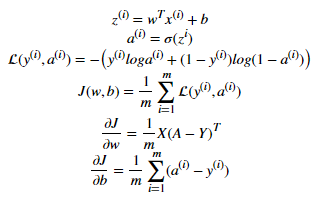

In [5]:
from IPython.display import Image, display
Image('images/formular.png', width=350)

### 2 - building the part of our algorithm

The main step for building a neural network are:

 - define the model structure
 - initialize the model's parameters
 - loop:
     - calculate the current loss(forward propagation)
     - calculate the current gradient(backward propagation)
     - updates paramenters(gradient descent)

we often building 1-3 separately and integrate them into one function in the right order

####  2.1 - helper function

In [10]:
def sigmoid(z):
    a = 1./(1. + np.exp(-z))
    return a

In [11]:
print(sigmoid(np.array([-2., 0., 2.])))

[ 0.11920292  0.5         0.88079708]


#### 2.2 - initializing parameters

In [12]:
def initialize_with_zeros(dim):
    w, b = np.zeros((dim, 1)), 0.
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    para = {'w':w, 'b':b}
    return para

In [13]:
initialize_para = initialize_with_zeros(2)
print('w:', initialize_para['w'])
print('b:', initialize_para['b'])

w: [[ 0.]
 [ 0.]]
b: 0.0


#### 2.3 - propagation

In [14]:
def propagation(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))/(-m)
    dw = np.dot(X, (A - Y).T)/m
    db = np.sum(A - Y)/m
    
    assert(A.shape == (1, m))
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {'dw':dw, 'db':db}
    return grads, cost

In [15]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagation(w, b, X, Y)
print('dw:', grads['dw'])
print('db:', grads['db'])
print('cost:', cost)

dw: [[ 0.99845601]
 [ 2.39507239]]
db: 0.00145557813678
cost: 5.80154531939


#### 2.4 - optimization

In [16]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagation(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if i % 100 == 0 and print_cost == True:
            print('cost after interation %d : %f' % (i, cost))
    
    params = {'w':w, 'b':b}
    grads = {'dw':dw, 'db':db}
    return params, grads, costs

In [17]:
params, grads, costs = optimize(w, b, X, Y, num_iterations = 100, learning_rate = 0.009, print_cost = True)
print('w:', params['w'])
print('b:', params['b'])
print('dw:', grads['dw'])
print('db:', grads['db'])
print('cost:', cost)

cost after interation 0 : 5.801545
w: [[ 0.19033591]
 [ 0.12259159]]
b: 1.92535983008
dw: [[ 0.67752042]
 [ 1.41625495]]
db: 0.219194504541
cost: 5.80154531939


#### 2.5 - prediction

In [18]:
def predict(w, b, X):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    Y_prediction = np.where(A > 0.5, 1, 0)
    
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [19]:
w, b = np.array([[0.1124579],[0.23106775]]), -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


### 3 - Merge all functions into  a model

In [20]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost = False):
    feature_dim = X_train.shape[0]
    initial_params = initialize_with_zeros(feature_dim)
    w = initial_params['w']
    b = initial_params['b']
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params['w']
    b = params['b']
    train_predict = predict(w, b, X_train)
    test_predict = predict(w, b, X_test)
    
    print('train accuracy: %f%%' % (np.sum(np.where(train_predict == Y_train, 1, 0))/len(np.squeeze(Y_train)) * 100))
    print('test accuracy: %f%%' %(np.sum(np.where(test_predict == Y_test, 1, 0))/len(np.squeeze(Y_test)) * 100))
    
    d = {'costs':costs,
         'train_predict':train_predict,
         'test_predict':test_predict,
         'learning_rate':learning_rate,
         'num_interation':num_iterations,
         'w':w,
         'b':b,}
    return d

In [21]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

cost after interation 0 : 0.693147
cost after interation 100 : 0.584508
cost after interation 200 : 0.466949
cost after interation 300 : 0.376007
cost after interation 400 : 0.331463
cost after interation 500 : 0.303273
cost after interation 600 : 0.279880
cost after interation 700 : 0.260042
cost after interation 800 : 0.242941
cost after interation 900 : 0.228004
cost after interation 1000 : 0.214820
cost after interation 1100 : 0.203078
cost after interation 1200 : 0.192544
cost after interation 1300 : 0.183033
cost after interation 1400 : 0.174399
cost after interation 1500 : 0.166521
cost after interation 1600 : 0.159305
cost after interation 1700 : 0.152667
cost after interation 1800 : 0.146542
cost after interation 1900 : 0.140872
train accuracy: 99.043062%
test accuracy: 70.000000%


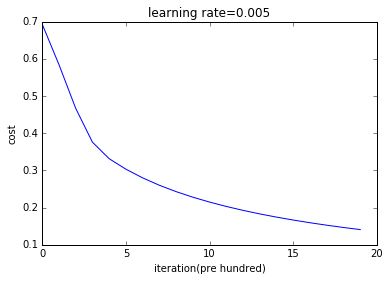

In [22]:
plt.rcParams['figure.figsize'] = (6, 4)
costs = d['costs']
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iteration(pre hundred)')
plt.title('learning rate=' + str(d['learning_rate']))
plt.show()

### 4 - Further analysis

In order for gradient descent to work you must be choose the learning rate wisely. The learning rate determine how rapidly we update the parameters. If the learning rate too large we may "overshoot" the optimal value, similiary, if it is too small we will need too many iterations to converge to the best value. That is why it's crucial to use a well-tuned learning rate.

train accuracy: 98.564593%
test accuracy: 70.000000%

 -------------------------------------------------------------------------------- 

train accuracy: 86.602871%
test accuracy: 62.000000%

 -------------------------------------------------------------------------------- 

train accuracy: 66.028708%
test accuracy: 36.000000%

 -------------------------------------------------------------------------------- 



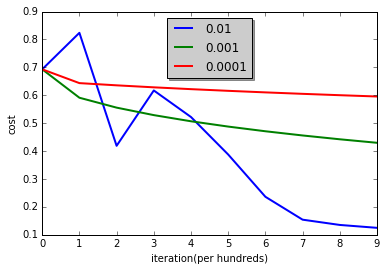

In [23]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1000, 
                           learning_rate=i, print_cost=False)
    print('\n', '-' * 80, '\n')
    plt.plot(models[str(i)]['costs'], label = str(models[str(i)]['learning_rate']), lw=2)

plt.xlabel('iteration(per hundreds)')
plt.ylabel('cost')
legend = plt.legend(loc = 'upper center', shadow = True)
frame = legend.get_frame()
frame.set_facecolor('0.80')
plt.show()

### 5 - Application for cat recognition

In [24]:
from scipy import ndimage
import scipy

# training model
cat_recognition_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, 
                              learning_rate=0.005, print_cost=True)
w = cat_recognition_model['w']
b = cat_recognition_model['b']

cost after interation 0 : 0.693147
cost after interation 100 : 0.584508
cost after interation 200 : 0.466949
cost after interation 300 : 0.376007
cost after interation 400 : 0.331463
cost after interation 500 : 0.303273
cost after interation 600 : 0.279880
cost after interation 700 : 0.260042
cost after interation 800 : 0.242941
cost after interation 900 : 0.228004
cost after interation 1000 : 0.214820
cost after interation 1100 : 0.203078
cost after interation 1200 : 0.192544
cost after interation 1300 : 0.183033
cost after interation 1400 : 0.174399
cost after interation 1500 : 0.166521
cost after interation 1600 : 0.159305
cost after interation 1700 : 0.152667
cost after interation 1800 : 0.146542
cost after interation 1900 : 0.140872
train accuracy: 99.043062%
test accuracy: 70.000000%


This is a cat picture


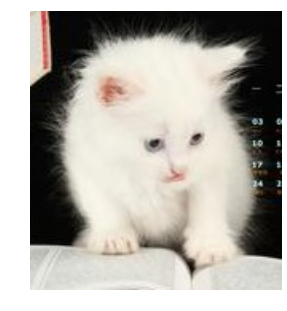

In [25]:
# get user's images
user_images_name = r'images/user_images_2.jpg'  # specified by user
num_pix = train_set_x_orig.shape[1]
image = np.array(ndimage.imread(user_images_name, flatten = False))
resize_image = scipy.misc.imresize(image, size=(num_pix, num_pix)).reshape((num_pix * num_pix * 3, 1))

# prediction
user_image_predict = predict(w, b, resize_image)
print('This is a ' + str(classes[np.squeeze(user_image_predict)].decode('utf-8')) + ' picture')
plt.rcParams['figure.figsize'] = (5, 5)
plt.imshow(image)
plt.axis('off')
plt.show()